# 7. Semantic segmentation

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F


import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
from torch.utils.data import DataLoader
from IPython.display import clear_output
from early_stopping.pytorchtools import EarlyStopping

%matplotlib inline
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


plt.rcParams['text.color'] = 'w'
plt.rcParams['xtick.color'] = 'w'
plt.rcParams['ytick.color'] = 'w'
plt.rcParams['axes.labelcolor'] = 'w'
font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 14}
plt.rc('font', **font)

from early_stopping.pytorchtools import EarlyStopping

* https://www.kaggle.com/cordmaur/38-cloud-simple-unet

In [2]:
class UNet(nn.Module):

    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.conv1 = self.encoder_block(in_channels, 32, 7, 3)
        self.conv2 = self.encoder_block(32, 64, 3, 1)
        self.conv3 = self.encoder_block(64, 128, 3, 1)

        self.upconv3 = self.decoder_block(128, 64, 3, 1)
        self.upconv2 = self.decoder_block(64*2, 32, 3, 1)
        self.upconv1 = self.decoder_block(32*2, out_channels, 3, 1)

    def forward(self, x):

        # downsampling part
        conv1 = self.conv1(x)
        conv2 = self.conv2(conv1)
        conv3 = self.conv3(conv2)

        upconv3 = self.upconv3(conv3)

        upconv2 = self.upconv2(torch.cat([upconv3, conv2], 1))
        upconv1 = self.upconv1(torch.cat([upconv2, conv1], 1))

        return upconv1

    def encoder_block(self, in_channels, out_channels, kernel_size, padding):

        contract = nn.Sequential(
            torch.nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
            torch.nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
                                 )

        return contract

    def decoder_block(self, in_channels, out_channels, kernel_size, padding):

        expand = nn.Sequential(torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=padding),
                            torch.nn.BatchNorm2d(out_channels),
                            torch.nn.ReLU(),
                            torch.nn.Conv2d(out_channels, out_channels, kernel_size, stride=1, padding=padding),
                            torch.nn.BatchNorm2d(out_channels),
                            torch.nn.ReLU(),
                            torch.nn.ConvTranspose2d(out_channels, out_channels, kernel_size=3, stride=2, padding=1, output_padding=1)
                            )
        return expand

In [3]:
def train(model, n_epochs,train_loader,valid_loader,criterion,optimizer,scheduler=None,early_stop_count=0):
    avg_train_losses = []
    avg_valid_losses = []
    avg_valid_acc = []
    batch_train_losses= []

    early_stopping = EarlyStopping(patience=early_stop_count, verbose=True, path="net.pth")

    for epoch in range(1, n_epochs + 1):
        train_losses = []
        valid_losses = []
        valid_accs = []

        model.train() # prep model for training
        for input_data, classes in train_loader:
            data = input_data.to(device)
            target = classes.long().to(device)

            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())

        model.eval()
        for input_data, classes in valid_loader:
            data = input_data.to(device)
            target = classes.long().to(device)

            output = model(data)
            loss = criterion(output, target)
            valid_losses.append(loss.item())

            _, pred = torch.max(output, 1)

            valid_accs.append(np.sum(target.cpu().numpy().ravel() == pred.cpu().numpy().ravel()) / len(target.cpu().numpy().ravel()) )

        train_loss = np.average(train_losses)
        valid_loss = np.average(valid_losses)
        valid_acc = np.average(valid_accs)

        if scheduler:
            scheduler.step()

        avg_train_losses.append(train_loss)
        avg_valid_losses.append(valid_loss)
        avg_valid_acc.append(valid_acc)
        batch_train_losses.extend(train_losses)

        epoch_len = len(str(n_epochs))

        print_msg = (f'[{epoch:>{epoch_len}}/{n_epochs:>{epoch_len}}] ' +
                     f'train_loss: {train_loss:.5f} ' +
                     f'valid_loss: {valid_loss:.5f} '
                     f'valid_acc: {valid_acc*100:2.2f} %')
        if scheduler:
            print_msg = print_msg + " lr: {:.5f}".format(scheduler.get_last_lr()[0])
        print(print_msg)

        if early_stop_count:
            early_stopping(valid_loss, model)

            if early_stopping.early_stop:
                print("Early stopping")
                break
    if early_stop_count:
        model.load_state_dict(torch.load("net.pth"))

    return avg_valid_losses, avg_train_losses, model, batch_train_losses

In [4]:
from sklearn import metrics
from skimage.measure import label, regionprops_table
import pandas

def postprocess_image(img,number_of_objects=1):
    label_image = label(img)
    region_dict = regionprops_table(label_image,properties=('centroid','area','coords'))
    df = pandas.DataFrame(region_dict)
    post_im = np.zeros(img.shape)
    if np.max(label_image)>0:
        for i in range(number_of_objects):
            if np.max(label_image)>1:
                index = df['area'].idxmax()
                indices = region_dict['coords'][index]
                post_im[indices[:,0],indices[:,1]] = 1
                df = df.drop(labels=index, axis=0)
            else:
                index = df['area'].idxmax()
                indices = region_dict['coords'][index]
                post_im[indices[:,0],indices[:,1]] = 1
    return post_im

def visualize_loss(avg_valid_losses,avg_train_losses):
    plt.figure()
    xx = np.arange(0,len(avg_valid_losses),1)
    y_valid = np.array(avg_valid_losses)
    y_train =  np.array(avg_train_losses)
    plt.plot(xx, y_valid)
    plt.plot(xx, y_train,color='red')
    plt.legend(("Validation Loss","Training Loss"),labelcolor='black')
    plt.xlabel("Epochs")
    plt.ylabel("loss")
    plt.title("Loss of validation and training set")
    plt.show()

def visualize_prediction(model,test_loader,pred_class):
    fig, axs = plt.subplots(4, 5, figsize=(20,10))
    input_data, classes =next(iter(test_loader))
    x = input_data.to(device)
    y = classes.long().to(device)
    output = model(x)
    pred = torch.softmax(output, 1)

    for i in range(4):
        axs[i,0].imshow(x.cpu().numpy()[i,0,:,:])
        axs[i,0].axis("off")

        axs[i,1].imshow(y.cpu().numpy()[i,:,:])
        axs[i,1].set_title("Ground truth mask")
        axs[i,1].axis("off")

        axs[i,2].imshow(pred.detach().cpu().numpy()[i,0,:,:])
        axs[i,2].set_title("Background min: {:.2f} max: {:.2f}"
                           "".format(torch.min(pred[i,0,:,:]),torch.max(pred[i,0,:,:])))
        axs[i,2].axis("off")

        axs[i,3].imshow(pred.detach().cpu().numpy()[i,1,:,:])
        axs[i,3].set_title("Lung class min: {:.2f} max: {:.2f}"
                           "".format(torch.min(pred[i,1,:,:]),torch.max(pred[i,1,:,:])))
        axs[i,3].axis("off")
        if pred_class == "rib":
            axs[i,4].imshow(postprocess_image(pred.detach().cpu().numpy()[i,1,:,:]>0.5,number_of_objects=2))
            axs[i,4].set_title("Lung class min: {:.2f} max: {:.2f}"
                           "".format(torch.min(pred[i,1,:,:]),torch.max(pred[i,1,:,:])))
            axs[i,4].axis("off")
        else:
            axs[i,4].imshow(postprocess_image(pred.detach().cpu().numpy()[i,1,:,:]>0.5,number_of_objects=1))
            axs[i,4].set_title("Lung class min: {:.2f} max: {:.2f}"
                           "".format(torch.min(pred[i,1,:,:]),torch.max(pred[i,1,:,:])))
            axs[i,4].axis("off")

def print_performance(model, test_loader, with_post=False):
    tn_s = 0
    fp_s = 0
    fn_s = 0
    tp_s = 0

    unet.eval()
    for x, y in test_loader:
        x = x.cuda()
        y_pred = model(x)
        y_pred = torch.softmax(y_pred, dim=1)
        y_pred = (y_pred[:,1,:,:]>0.5).detach().cpu().numpy()
        if with_post:
            for i in range(y_pred.shape[0]):
                y_pred[i,:,:] = postprocess_image(y_pred[i,:,:])
        y_pred = y_pred.ravel()
        y = y.detach().cpu().numpy().ravel() == 1
        tn, fp, fn, tp  = metrics.confusion_matrix(y,y_pred).ravel()
        tn_s=tn_s+tn
        fp_s=fp_s+fp
        fn_s=fn_s+fn
        tp_s=tp_s+tp

    tn, fp, fn, tp = np.array([[tn_s,fp_s],[fn_s,tp_s]]).ravel()

    accuracy  = (tp+tn) / (tp + tn + fp +fn)
    precision = tp / (tp + fp)
    recall  = tp / (tp + fn)
    jaccard  = tp / (tp+fp+fn)
    dice  = 2*jaccard/(1+jaccard)

    print("Accuracy:\t{:.4f}\nRecall:  \t {:.4f}\nPrecision\t{:.4f}\nDice coef(F1)\t{:.4f}\n"
          "IoU\t {:.4f}\n".format(accuracy,recall,precision,dice,jaccard))

In [5]:
from PIL import Image
import numpy as np
import torch
import os
import matplotlib.pyplot as plt
from torchvision import transforms, utils

from torch.utils.data import Dataset
from pathlib import Path
import itertools

class LungSegDataset(Dataset):

    def __init__(self, dataset_dir,transform=None,sel_class="lung"):
        super(LungSegDataset).__init__()
        self.classes = [os.path.basename(f) for f in dataset_dir.iterdir() if f.is_dir()]
        self.files = [self.dict_of_classes(f) for f in (dataset_dir / self.classes[0]).iterdir()]
        self.transform = transform
        self.sel_class = sel_class

    def dict_of_classes(self, filepath):
        sample = {}
        for dataset_class in self.classes:
            sample[dataset_class] = Path(str(filepath).replace(self.classes[0], dataset_class))
        return sample

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img = Image.open(self.files[idx]['img'])
        mask = Image.open(self.files[idx][self.sel_class])
        if self.transform:
            img = self.transform(img)
            mask = self.transform(mask)

        return img,torch.squeeze(mask)

    def __repr__(self):
        s = 'Dataset class with {} allfiles'.format(self.__len__())
        return s

    def get_class_weights(self,number_of_samples=10,ce_type="dist"):
        stack = list()
        indices = np.random.randint(0,len(self),number_of_samples)
        for index in indices:
            _, mask = self.__getitem__(index)
            stack += mask.numpy().ravel().tolist()
        stack = np.array(stack)
        sum_pos = np.sum(stack)
        sum_neg = stack.shape[0]-sum_pos
        if ce_type=="dist":
            weights =  np.array([(sum_pos+sum_neg)/(2*sum_neg),(sum_pos+sum_neg)/(2*sum_pos)])
        else:
            weights = np.array([sum_neg/stack.shape[0],sum_pos/stack.shape[0]])
        return torch.tensor(weights,dtype=torch.float).cuda()

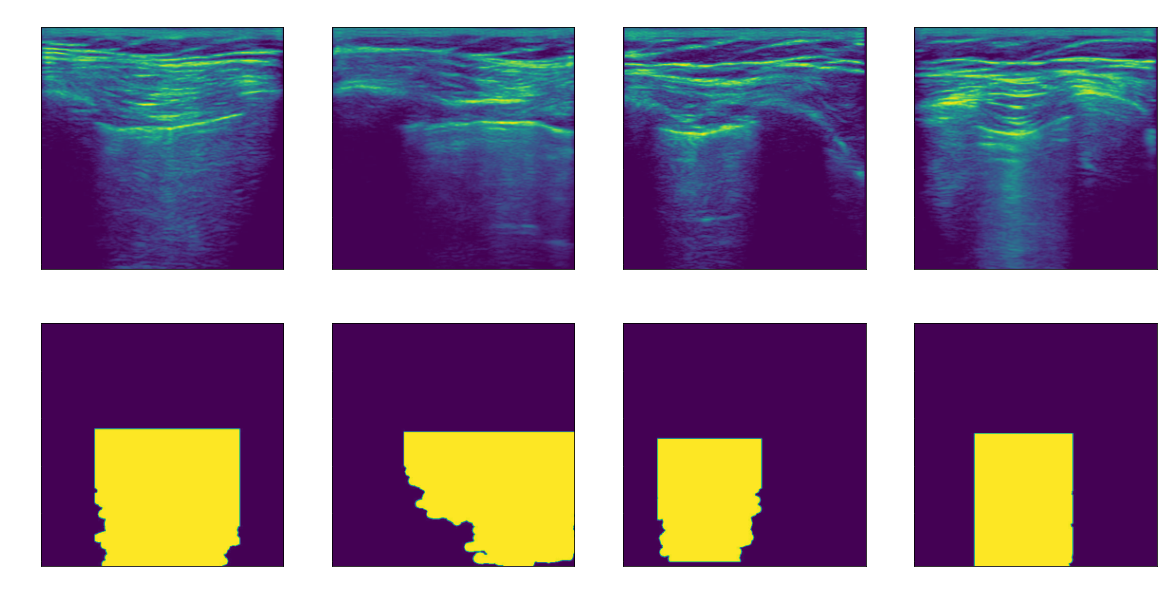

In [6]:
unet = UNet(1,2)
min_transform = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor()
    ])

dataset = LungSegDataset(dataset_dir=Path("/media/miro/4tb_cached/usg_data/base_seg_dataset"),
                         transform=min_transform,
                         sel_class="lung")
fig, axs = plt.subplots(2, 4,figsize=(20,10))
sample = np.random.randint(0,len(dataset),64)
for i in range(4):
    img, target = dataset.__getitem__(sample[i])
    img = img.permute(1,2,0)
    axs[0,i].imshow(img)
    axs[0,i].set_title("min: {:.2f} max: {:.2f}".format(torch.min(target),torch.max(target)))
    axs[1,i].imshow(torch.squeeze(target))
    axs[1,i].set_title("min: {:.2f} max: {:.2f}".format(torch.min(target),torch.max(target)))

In [7]:
batch_size =  4
split = (0.5, 0.25, 0.25)
training_samples = int(len(dataset) * split[0])
validation_samples = int(len(dataset) *  split[1])
test_samples = len(dataset) - training_samples - validation_samples
train_ds, valid_ds, test_ds = torch.utils.data.random_split(dataset, (training_samples, validation_samples, test_samples))

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_ds, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=True)

### Different loss functions
* https://github.com/JunMa11/SegLoss
* https://arxiv.org/abs/2006.14822v4
* certain loss function are unstable for tasks with noisy and unabalanced data

In [8]:
from SegLoss.losses_pytorch.dice_loss import IoULoss,SoftDiceLoss,SSLoss

In [9]:
unet = UNet(1,2)
unet = unet.to(device)
weights = dataset.get_class_weights(10)
print(weights)
criterion = torch.nn.CrossEntropyLoss(weight=weights)
optimizer = torch.optim.Adam(unet.parameters(),lr=1e-3)

tensor([0.6084, 2.8072], device='cuda:0')


In [10]:
avg_valid_losses, avg_train_losses, model,batch_train_losses = train(unet,
                                                                     40,
                                                                     train_loader,
                                                                     valid_loader,
                                                                     criterion=criterion,
                                                                     optimizer=optimizer,
                                                                     early_stop_count=5)
visualize_loss(avg_valid_losses,avg_train_losses)
print_performance(unet,test_loader)

KeyboardInterrupt: 

In [ ]:
visualize_prediction(unet,test_loader,dataset.sel_class)

In [ ]:
print_performance(unet,test_loader,with_post=True)

In [ ]:
from glob import glob
from tqdm.notebook import  tqdm
from torch.utils import data
from skimage import io

class BModeDataset(data.Dataset):

    def __init__(self,
                 root_fp='/media/miro/4tb_cached/usg_data/base_dataset/frames/',
                 transform=None):
        super(BModeDataset, self).__init__()
        self.transform = transform
        self.image_list = sorted(glob(os.path.join(root_fp, '*/*/*.png')))

        self.classes = np.zeros((len(self.image_list)))
        self.identifiers = list()
        self.data = list()
        for idx, fp in enumerate(tqdm(self.image_list)):
            if "lung_sliding_absence" in self.image_list[idx]:
                self.classes[idx] = 1
            self.identifiers +=[str.split(os.path.split(self.image_list[idx])[1], "frame")[0]]
            self.data += [Image.open(self.image_list[idx])]
            #self.data += [io.imread(self.image_list[idx])]

    def __getitem__(self, index):
        img = self.data[index]
        if self.transform:
            img = self.transform(img)

        return img, self.classes[index], str.split(os.path.split(self.image_list[index])[1], "frame")[0]

    def __len__(self):
        return len(self.image_list)

In [ ]:
frame_dataset = BModeDataset(transform=min_transform)
img,_,_ = frame_dataset.__getitem__(0)

In [ ]:
bs = 1

for idx in tqdm(range(len(frame_dataset))):
    post_im = []
    with torch.no_grad():
        img,_,_ = frame_dataset.__getitem__(idx)
        output = unet(torch.unsqueeze(img,0).cuda())
        pred = torch.softmax(output, 1)
        post_im = postprocess_image(pred.detach().cpu().numpy()[0,1,:,:]>0.5,number_of_objects=2)

    filepath = frame_dataset.image_list[idx]
    filepath = filepath.replace("/frames/","/rib_mask_ce/")
    if os.path.exists(os.path.dirname(filepath)):
        io.imsave(filepath,(post_im*255).astype(np.uint8))
    else:
        os.makedirs(os.path.dirname(filepath))
        io.imsave(filepath,(post_im*255).astype(np.uint8))
